In [1]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

In [2]:
import talib

def get_technical_indicator(kbars):
    
#     kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
    macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
    kbars['macd'] = macd
    kbars['macdsignal'] = macdsignal
    kbars['macdhist'] = macdhist
    
    kbars['slowk'], kbars['slowd'] = talib.STOCH(kbars.high,
                        kbars.low,
                        kbars.close,
                        fastk_period=9,
                        slowk_period=3,
                        slowk_matype=0,
                        slowd_period=3,
                        slowd_matype=0)    
    
    return kbars

In [16]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    prev_trading_date_ticks = get_ticks(code, prev_trading_date, connection, api)
    ticks = prev_trading_date_ticks[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks)
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_low_price = ticks_to_kbars(prev_trading_date_ticks[0]).low.min()
    prev_high_price = ticks_to_kbars(prev_trading_date_ticks[0]).high.max()
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    prev_open_high_price = kbars['high'].get(pd.to_datetime(prev_trading_date).replace(hour=9, minute=0))
    prev_last_high_price = kbars['high'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
#     判斷昨日多空
    long = False
    if (
        prev_last_high_price is not None and
        prev_open_high_price is not None and
        prev_close_price is not None and
        prev_last_high_price >= prev_high_price and
        prev_last_high_price > prev_open_high_price and
        prev_close_price >= prev_low_price):
        long = True
    kbars = kbars[date:]
            
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
    open_price = 0
    stop_loss_price = 0
    strong = False
    red_k_standard = 0
    
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]

        if ts == 0: 
            open_price = kbars['open'][ts]
            continue
        if ts ==1:
            if(kbars['close'][0] >= open_price * 1.04 && kbars.iloc[0]['cci'] >= 400):
                break
#             判斷開盤強弱
            if kbars['close'][0] > prev_high_price and kbars['close'][0] > open_price:
                red_k_standard = abs(kbars['close'][0] - kbars['open'][0])
                stop_loss_price = kbars['low'][0]
                strong = True
            continue
                
        
        if (
            current_time <= date.replace(hour=10, minute=30, second=0) and
            long == True and 
            strong == True and
            position == 0
        ):
            position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        elif (
            current_time <= date.replace(hour=13, minute=20, second=0) and
            current_price > open_price * 1.09 and position != 0
        ):
            exit_price = current_price
            exit_time = current_time.time()
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
        elif (
            current_time <= date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            if (
                kbars['close'][ts-1] > kbars['open'][ts-1] and
                kbars['volume'][ts-1] >= 100 and
                abs(kbars['close'][ts-1] > kbars['open'][ts-1]) >= red_k_standard * 0.58 and
                kbars['low'][ts-1] > stop_loss_price):
                stop_loss_price = kbars['low'][ts-1]
            if (current_price >= stop_loss_price):
                print('[{}] current price is {}, stop loss price is {}'.format(current_time, current_price, stop_loss_price))
                continue
            exit_price = current_price
            exit_time = current_time.time()
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            break
            
        elif (
            current_time > date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

SyntaxError: invalid syntax (<ipython-input-16-895e1a681916>, line 49)

In [4]:
import json

with open('config.json') as f:
  config = json.load(f)

api = sj.Shioaji()
api.login(
    person_id = config['account'],
    passwd= config['password'],
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
<SecurityType.Index: 'IND'> fetch done.


In [5]:
def get_trading_codes(codes, connection, api):
    trading_codes = []
    for code in codes:
        stock = get_stock(code, connection, api)
        if not stock[0].empty and stock[0].iloc[0]['day_trade'] == 'Yes':
            trading_codes.append(code)
    return trading_codes

In [6]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)

#         day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        day_trading_codes = get_trading_codes(codes, connection, api)
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [17]:
transactions = backtest('2021/1/1', '2021/3/12', connection, api)
transactions 

20210208 找不到資料
20210209 找不到資料
[2021-01-12 09:10:00] buy 1524 at 12.35
[2021-01-12 09:15:00] current price is 12.35, stop loss price is 0
[2021-01-12 09:20:00] current price is 12.35, stop loss price is 0
[2021-01-12 09:25:00] current price is 12.15, stop loss price is 0
[2021-01-12 09:30:00] current price is 11.85, stop loss price is 0
[2021-01-12 09:35:00] current price is 11.95, stop loss price is 11.7
[2021-01-12 09:40:00] current price is 12.0, stop loss price is 11.9
[2021-01-12 09:45:00] current price is 12.05, stop loss price is 11.9
[2021-01-12 09:50:00] current price is 12.2, stop loss price is 12.0
[2021-01-12 09:55:00] current price is 12.25, stop loss price is 12.0
[2021-01-12 10:00:00] current price is 12.15, stop loss price is 12.0
[2021-01-12 10:05:00] current price is 12.2, stop loss price is 12.1
[2021-01-12 10:10:00] current price is 12.3, stop loss price is 12.15
[2021-01-12 10:15:00] current price is 12.25, stop loss price is 12.15
[2021-01-12 10:20:00] current pric

,股票代號,買進時間,買進價格,買進股數,買進金額,賣出時間,賣出價格,賣出股數,賣出金額,買進手續費,賣出手續費,交易稅,損益
成交日期,,,,,,,,,,,,,
2021-01-12,1524,09:10:00,12.35,2000,24700.0,11:00:00,12.20,2000,24400.0,20,20,36,-376.0
2021-01-14,2491,09:10:00,11.50,2000,23000.0,09:40:00,11.45,2000,22900.0,20,20,34,-174.0
2021-02-18,2017,09:10:00,11.00,2000,22000.0,10:15:00,11.10,2000,22200.0,20,20,33,127.0
2021-02-19,2611,09:10:00,11.00,2000,22000.0,10:55:00,10.00,2000,20000.0,20,20,30,-2070.0
2021-02-19,5608,09:10:00,11.90,2000,23800.0,09:40:00,11.60,2000,23200.0,20,20,34,-674.0


In [18]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-12,24700.0,20,24400.0,20,36,-376.0,1.0
2021-01-14,23000.0,20,22900.0,20,34,-174.0,1.0
2021-02-18,22000.0,20,22200.0,20,33,127.0,1.0
2021-02-19,45800.0,40,43200.0,40,64,-2744.0,2.0


In [19]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-01-31,47700.0,40,47300.0,40,70,-550.0,2.0
2021-02-28,67800.0,60,65400.0,60,97,-2617.0,3.0


In [20]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

-3167.0

Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (00006124) TCP: Could not read from socket 2676, error = Connection reset by peer (10054) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 3 of 3) | Event: Session reconnected


In [11]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

0.2

In [12]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 -2744.0


[Text(0.5, 0, 'profit loss')]

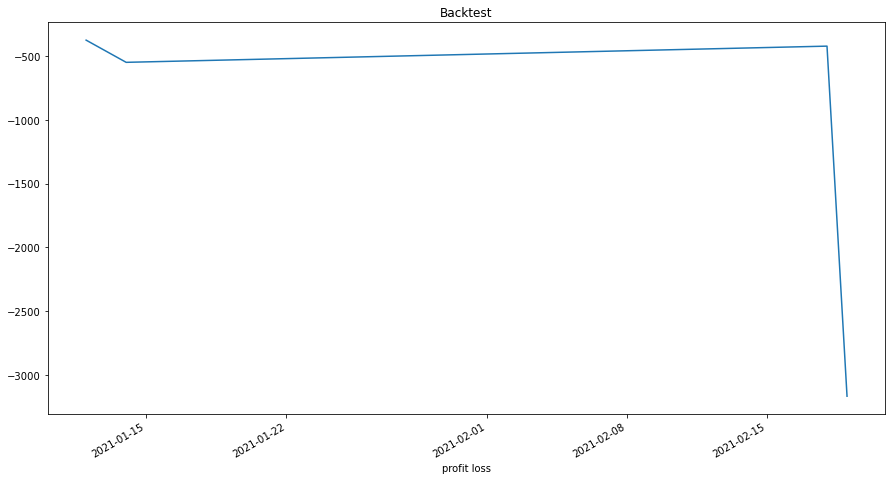

In [13]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')